<a href="https://colab.research.google.com/github/Rakeshscode/Data-Science/blob/main/Copy_of_Unit4ExerciesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import pymc as pm

# Unit 4 Exercises: Tinkering Hierarchical Models

These exercises are designed to force you to look at the nuances of the models we looked at in class, while exploring some "what ifs". There's also some mild data wrangling for you to enjoy at in task6.



**Task1**:

Redo the chemical shift hierarchical model, execpt with all Student T  and Half Student T likelihood and priors.

Then, compare group posteriors of the normal chem shift model with your new Student T model using a ridge plot.

In [3]:
#load the data from my github page.
#cs stands for chemical shift data
url_cs = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/chemical_shifts_theo_exp.csv'
#I could have put the url string directly into pd.read_csv()
cs_data = pd.read_csv(url_cs)

In [4]:
#element wise subtraction
diff_TminusE = cs_data.theo - cs_data.exp
#adds a column called 'diff_TminusE' as the fifth column of cs_data
cs_data.insert(loc=4,column='diff_TminusE',value=diff_TminusE)

In [5]:
#identifies all the different amino acids in our data set
#and stores that information, plus original info, in the variable aa_encode
aa_encode = pd.Categorical(cs_data['aa'])
aa_encode

['ILE', 'TYR', 'SER', 'ALA', 'ARG', ..., 'LYS', 'ARG', 'LYS', 'GLU', 'SER']
Length: 1776
Categories (19, object): ['ALA', 'ARG', 'ASN', 'ASP', ..., 'THR', 'TRP', 'TYR', 'VAL']

In [6]:
#Replaces all the amino acid names with a number in the variable aa_idx
aa_idx = aa_encode.codes
aa_idx

array([ 8, 17, 14, ..., 10,  5, 14], dtype=int8)

In [7]:
#stores the category names in a dictionary
#this dictionary format is required
#for pymc to properly read the categories
aa_coords = {"aa": aa_encode.categories}
aa_coords

{'aa': Index(['ALA', 'ARG', 'ASN', 'ASP', 'GLN', 'GLU', 'GLY', 'HIS', 'ILE', 'LEU',
        'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL'],
       dtype='object')}

In [14]:
with pm.Model(coords=aa_coords) as cs_h_model:
    # hyperpriors. Notice how there's no dims argument.
    #this means that the hyperprior is shared across all amino acids
    μ_mu = pm.StudentT('μ_mu', nu = 10, mu = 0, sigma = 10)
    μ_sd = pm.HalfStudentT('μ_sd', nu = 10, sigma = 10)
    μ_nu = pm.Exponential('μ_nu', lam = 1/30)

    # priors. There is a different prior for each amino acid,
    #but now the μ priors 'talk' to one another through μ_mu and μ_sd
    N = pm.Exponential('N', lam = 1/30,
                      dims = "aa")

    μ = pm.StudentT('μ',
                  nu = μ_nu,
                  mu = μ_mu,
                  sigma = μ_sd,
                  dims = "aa")

    σ = pm.HalfStudentT('σ', nu = μ_mu, sigma = 10,
                      dims = "aa")

    #likelihood; same as before
    y = pm.StudentT('y',
                  nu = N[aa_idx],
                  mu = μ[aa_idx],
                  sigma = σ[aa_idx],
                  observed = cs_data.diff_TminusE)

    #cs for chemshift, h for heirarchical
    idata_cs_h = pm.sample()

Output()

Output()

In [13]:
with pm.Model(coords=aa_coords) as cs_nh_model:
    # hyperpriors. Notice how there's no dims argument.
    #this means that the hyperprior is shared across all amino acids
    μ_mu = pm.Normal('μ_mu', mu = 0, sigma = 10)
    μ_sd = pm.HalfNormal('μ_sd', sigma = 10)

    # priors. There is a different prior for each amino acid,
    #but now the μ priors 'talk' to one another through μ_mu and μ_sd
    μ = pm.Normal('μ',
                  mu = μ_mu,
                  sigma = μ_sd,
                  dims = "aa")

    σ = pm.HalfNormal('σ', sigma = 10,
                      dims = "aa")

    #likelihood; same as before
    y = pm.Normal('y',
                  mu = μ[aa_idx],
                  sigma = σ[aa_idx],
                  observed = cs_data.diff_TminusE)

    #cs for chemshift, h for heirarchical
    idata_cs_nh = pm.sample()

Output()

Output()

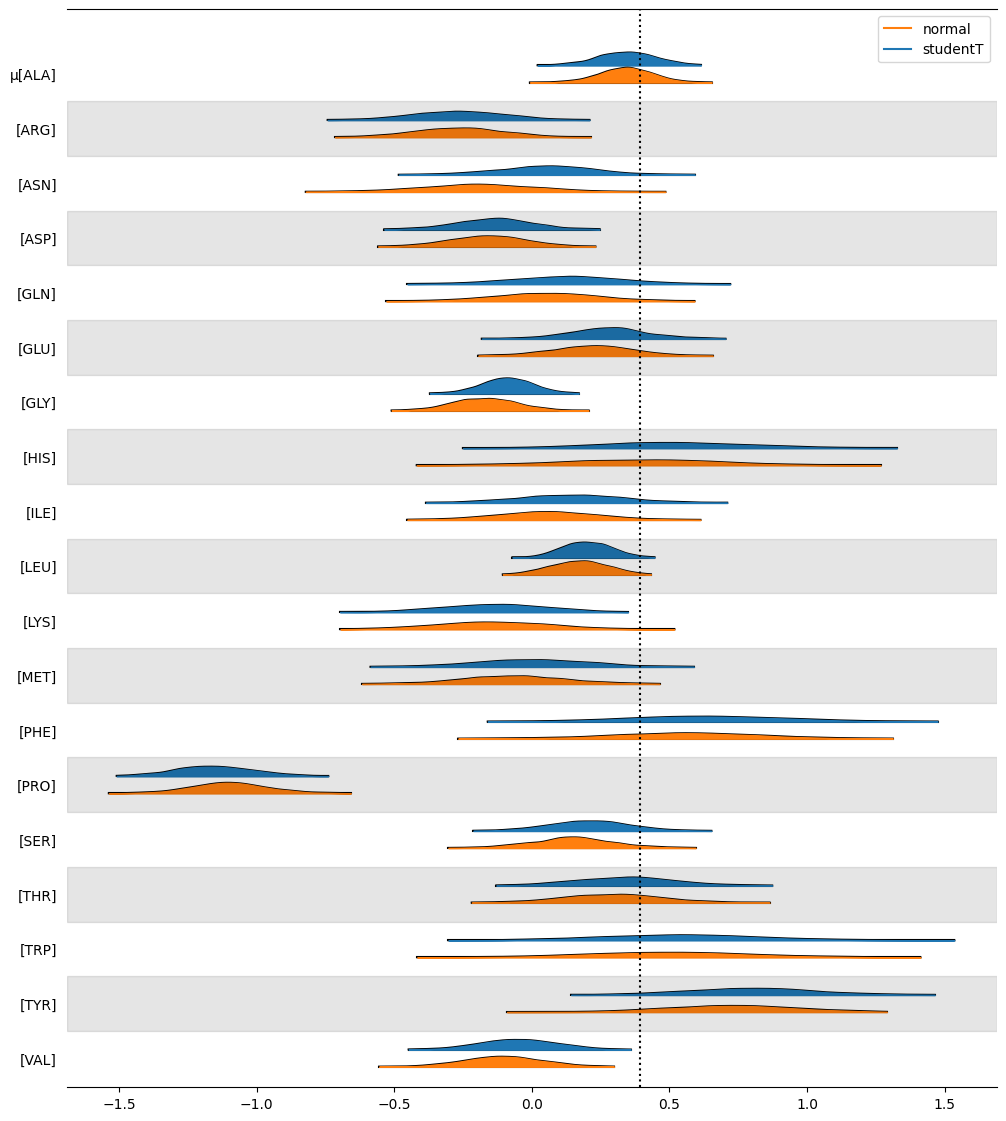

In [15]:
axes = az.plot_forest([idata_cs_h, idata_cs_nh], kind="ridgeplot",
                      model_names=['studentT', 'normal'],
                      var_names='μ', combined=True, figsize=(12, 14),hdi_prob=0.997)

y_lims = axes[0].get_ylim()
axes[0].vlines(idata_cs_h.posterior['μ_mu'].mean(), *y_lims, color="k", ls=":");

**Task2**:

Run a posterior predictive check for both models. Which seems to fit the data better?

Output()

Output()

<Axes: xlabel='y'>

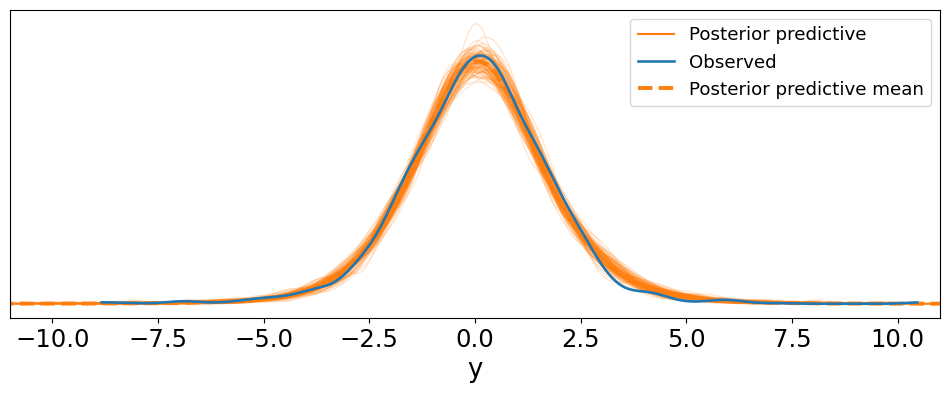

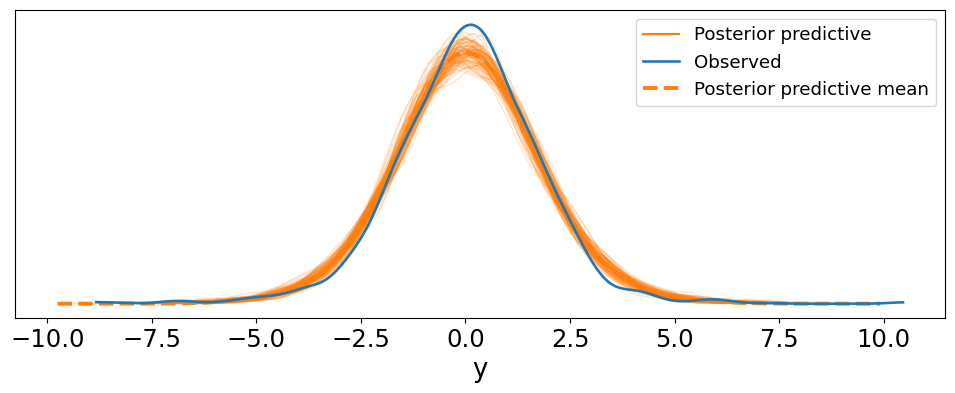

In [23]:
pm.sample_posterior_predictive(idata_cs_h, model=cs_h_model, extend_inferencedata=True)


#The following code block is taken from the textbook BAP3.
#Plots the posterior predictive density overlaid with a smoothed version of the data

ax = az.plot_ppc(idata_cs_h, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])
#need to limit the x axis, so its more readable
ax.set_xlim(-11, 11)

pm.sample_posterior_predictive(idata_cs_nh, model=cs_nh_model, extend_inferencedata=True)
az.plot_ppc(idata_cs_nh, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

The StudentT model seems to fit the data better.

**Task3**:

Redo the soccer model, but this time, assume the groups are independent. This will be a non-hierarchical model.

In [24]:
#load the data from my github page.
#sccr stands for soccer
url_sccr = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/football_players.csv'

#Turns the position column into a categorical variable
sccr_data = pd.read_csv(url_sccr,dtype={'position':'category'})

In [28]:
#this is an array of the soccer positions,
#except they are given an int (number) label instead of a string (of letters)
pos_idx = sccr_data.position.cat.codes.values

#an array of the four strings that represent position
pos_codes = sccr_data.position.cat.categories

#puts coords in a dict, so pymc can read them
sccr_coords = {"pos": pos_codes}






with pm.Model(coords = sccr_coords) as sccr_model:

    # Parameters for positions
    μ_p = pm.Beta('μ_p', alpha = 2, beta = 20, dims = "pos")

    ν_p = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="pos")

    # Parameter for players
    θ = pm.Beta('θ', mu = μ_p[pos_idx], nu = ν_p[pos_idx])

    #This tells our model how many shots and goals each player has
    _ = pm.Binomial('gs',
                    n = sccr_data.shots.values, #shots for each player
                    p = θ, #guess of goals per shot
                    observed = sccr_data.goals.values) #goals per player

    #target_accept has a default of 0.8. Increasing it makes us less likely to
    #have divergences
    idata_sccr = pm.sample(target_accept = 0.98)

Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


**Task4**:

Run plot trace and rhat on your inference data object for the non-hierarchical soccer model. How does this compare to the hierarchical model?

<xarray.Dataset> Size: 43kB
Dimensions:  (θ_dim_0: 2682, pos: 4)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 21kB 0 1 2 3 4 5 ... 2676 2677 2678 2679 2680 2681
  * pos      (pos) <U2 32B 'DF' 'FW' 'GK' 'MF'
Data variables:
    θ        (θ_dim_0) float64 21kB 1.0 1.002 1.002 1.005 ... 1.001 1.001 1.001
    μ_p      (pos) float64 32B 1.009 1.0 1.078 1.008
    ν_p      (pos) float64 32B 1.019 1.003 1.043 1.004

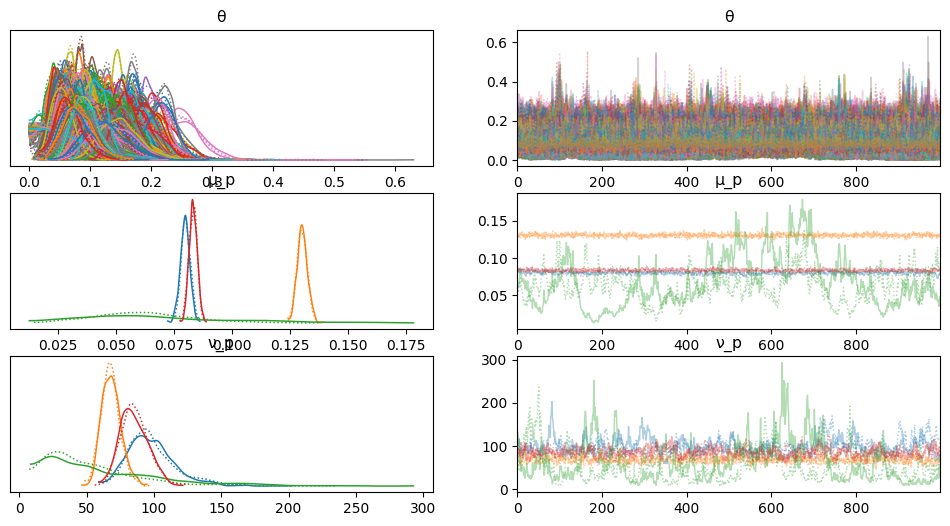

In [29]:
az.plot_trace(idata_sccr)


az.rhat(idata_sccr)

The rhat values of this non-hierarchial model are substantially closer to their ideal values than those of the hierarchial model (1 to 1.001). The GK values are high at 1.09 but they are still better than the GK value of 1.242 from the originla hierarchial model. Furthermore, there is a fair amount of similarity between the plot predictions and the observed data.

**Task5**:

Plot the posterior of the means for each soccer position in the non-hierarchical model.

How do these posteriors compare to the hierarchical model we did in class?

array([<Axes: >], dtype=object)

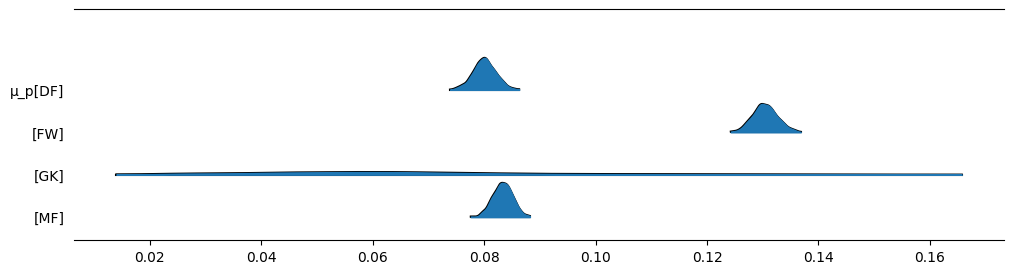

In [30]:
az.plot_forest(idata_sccr, var_names=['μ_p'], combined=True, figsize=(12, 3), kind = 'ridgeplot', hdi_prob=0.998)

These posteriors look similar to the ones from the hierarchial model we did in class. They seem to be a tiny bit more accurate shown by the fluidity and smoothness of them.

**Task6**:

Redo the soccer model as a hierarchical model, but remove all the goalkeepers (GK) from the data. In other words, run a hierarchical model on only the defenders, midfielders, and forwards.

In [31]:
sccr_data_noGK = sccr_data[sccr_data.position != 'GK'].copy() #Copies old soccer data
sccr_data_noGK['position'] = pd.Categorical(sccr_data_noGK['position']) #Takes just the GK position
sccr_data_noGK['position'] = sccr_data_noGK['position'].cat.remove_unused_categories() #Removes GK from new list

In [34]:
pos_idx_noGK = sccr_data_noGK.position.cat.codes.values #create position IDs for new list
pos_codes_noGK = sccr_data_noGK.position.cat.categories
sccr_coords_noGK = {"pos": pos_codes_noGK}

In [35]:
with pm.Model(coords = sccr_coords_noGK) as sccr_model_noG:
    # Hyper parameters
    #
    μ = pm.Beta('μ', alpha = 2, beta = 20)
    ν = pm.Gamma('ν', mu = 55, sigma = 45)


    # Parameters for positions
    μ_p = pm.Beta('μ_p', mu = μ, nu = ν, dims = "pos")

    ν_p = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="pos")

    # Parameter for players
    θ = pm.Beta('θ', mu = μ_p[pos_idx_noGK], nu = ν_p[pos_idx_noGK])

    #This tells our model how many shots and goals each player has
    _ = pm.Binomial('gs',
                    n = sccr_data_noGK.shots.values, #shots for each player
                    p = θ, #guess of goals per shot
                    observed = sccr_data_noGK.goals.values) #goals per player

    #target_accept has a default of 0.8. Increasing it makes us less likely to
    #have divergences
    idata_sccr_noGK = pm.sample(target_accept = 0.95)

Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


**Task7**:

Compare the plot trace and rhat results for the hierarchical model with GKs and without GKs. Then answer the following questions:
- Which model was easier for pymc to process?
- What do we lose by dropping Gks from the data set? What do we gain?

array([<Axes: >], dtype=object)

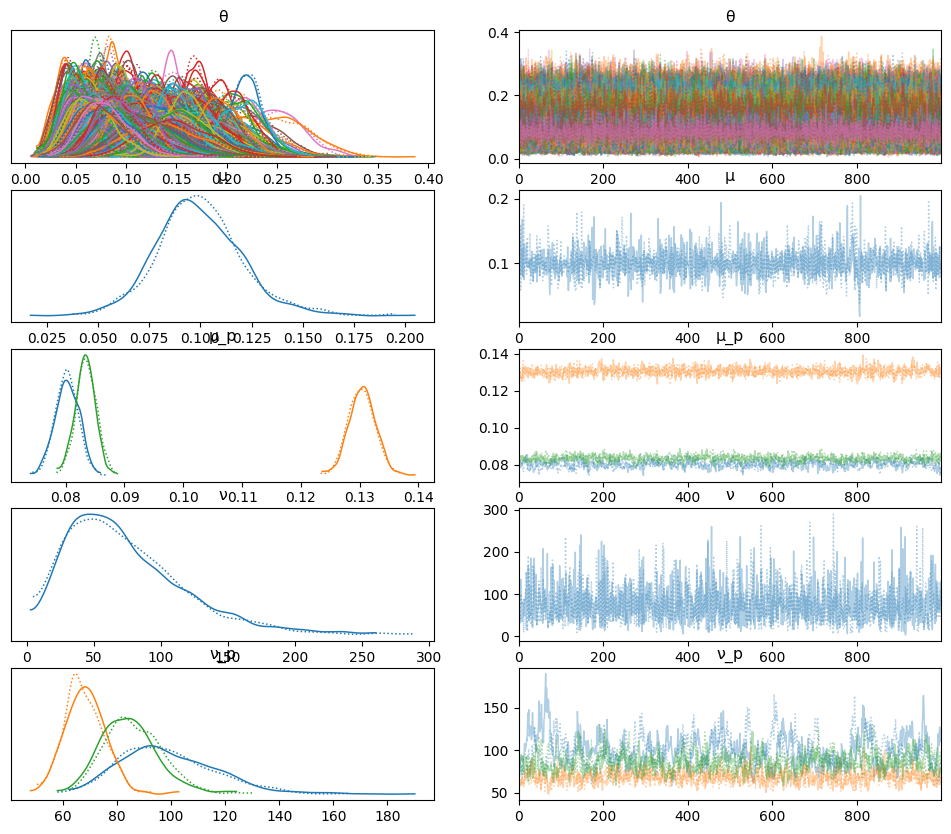

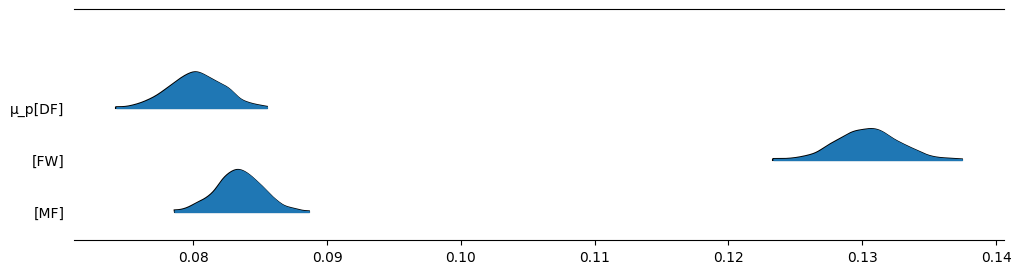

In [36]:
az.plot_trace(idata_sccr_noGK)
az.rhat(idata_sccr_noGK)
az.plot_forest(idata_sccr_noGK, var_names=['μ_p'], combined=True, figsize=(12, 3), kind = 'ridgeplot', hdi_prob=0.998)

I believe that the model without the GKs was easier for pymc to process because it took less than half the time since a portion of data was cut. Also without the GKs the model is neater and information on the other positions is easier to interpret. When we drop the GKs we lose the potential scoring data for the GKs but since it is rare for a GK to score anyway this data ends up skewing the model. We gain model run time speed and readability for the graphs.